In [ ]:
!pip install nltk
!pip install scikit-learn
!pip install tensorflow


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords
nltk.download('stopwords')
results = []



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/refs/heads/master/data/labeled_data.csv"
df = pd.read_csv(url)
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df['label'] = df['class'].apply(lambda x: 1 if x == 0 else 0)
df[['tweet', 'class', 'label']].head()


,tweet,class,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,2,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,0


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    return text

df['clean_tweet'] = df['tweet'].apply(clean_text)
df[['tweet', 'clean_tweet', 'label']].head()



,tweet,clean_tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt mayasolovely woman shouldnt complain cleani...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt mleew boy dats coldtyga dwn bad cuffin dat ...,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt urkindofbrand dawg rt sbabylife ever fuck b...,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt cganderson vivabased look like tranny,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shenikaroberts shit hear might true might f...,0


In [ ]:
vocab_size = 10000
max_length = 100
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_tweet'])
sequences = tokenizer.texts_to_sequences(df['clean_tweet'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

labels = np.array(df['label'])



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
embedding_dim = 100
gru_units_1 = 128
gru_units_2 = 64
dropout_rate = 0.4



In [ ]:
results = []

embedding_dim = 100
gru_unit_options = [64, 128]
dropout_options = [0.3, 0.4, 0.5]

for gru1 in gru_unit_options:
    for dropout_rate in dropout_options:

        model = Sequential([
            Embedding(vocab_size, embedding_dim, input_length=max_length),
            Bidirectional(GRU(gru1, return_sequences=True)),
            Dropout(dropout_rate),
            Bidirectional(GRU(gru1 // 2)),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        history = model.fit(X_train[:5000], y_train[:5000],
                    validation_data=(X_test[:1000], y_test[:1000]),
                    epochs=1, batch_size=64, verbose=0)

        loss, accuracy = model.evaluate(X_test[:1000], y_test[:1000], verbose=0)
        print(f"✅ Done: GRU1={gru1}, Dropout={dropout_rate} → Accuracy: {accuracy:.4f}")
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        results.append({
            "embedding_dim": embedding_dim,
            "GRU_1_units": gru1,
            "GRU_2_units": gru1 // 2,
            "dropout": dropout_rate,
            "accuracy": accuracy,
            "loss": loss,
            "params": model.count_params()
        })


✅ Done: GRU1=64, Dropout=0.3 → Accuracy: 0.9430
✅ Done: GRU1=64, Dropout=0.4 → Accuracy: 0.9430
✅ Done: GRU1=64, Dropout=0.5 → Accuracy: 0.9430
✅ Done: GRU1=128, Dropout=0.3 → Accuracy: 0.9430
✅ Done: GRU1=128, Dropout=0.4 → Accuracy: 0.9430
✅ Done: GRU1=128, Dropout=0.5 → Accuracy: 0.9430


In [ ]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(GRU(64)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=8, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 266s 414ms/step - accuracy: 0.9385 - loss: 0.2240 - val_accuracy: 0.9401 - val_loss: 0.1650
Epoch 2/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 260s 411ms/step - accuracy: 0.9533 - loss: 0.1234 - val_accuracy: 0.9407 - val_loss: 0.1928
Epoch 3/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 261s 410ms/step - accuracy: 0.9742 - loss: 0.0751 - val_accuracy: 0.9330 - val_loss: 0.2448
Epoch 4/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 260s 407ms/step - accuracy: 0.9848 - loss: 0.0430 - val_accuracy: 0.9248 - val_loss: 0.2970
Epoch 5/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 263s 409ms/step - accuracy: 0.9910 - loss: 0.0301 - val_accuracy: 0.9161 - val_loss: 0.3443
Epoch 6/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 260s 406ms/step - accuracy: 0.9946 - loss: 0.0176 - val_accuracy: 0.9173 - val_loss: 0.3360
Epoch 7/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 251s 404ms/step - accuracy: 0.9943 - loss: 0.0174 - val_accuracy: 0.9219 - val_loss: 0.3835
Epoch 8/8
620/620 ━━━━━━━━━━━━━━━━━━━━ 263s 405ms/step - accuracy: 0.9954 - loss: 0

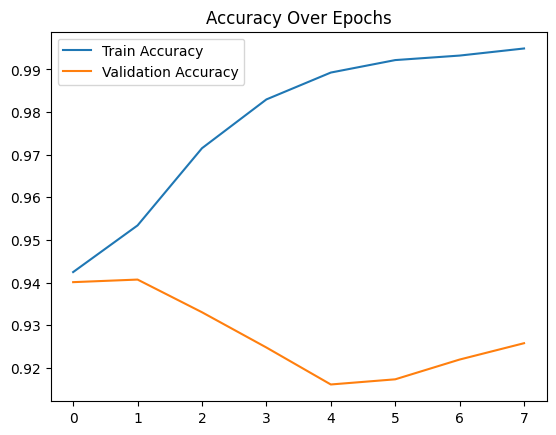

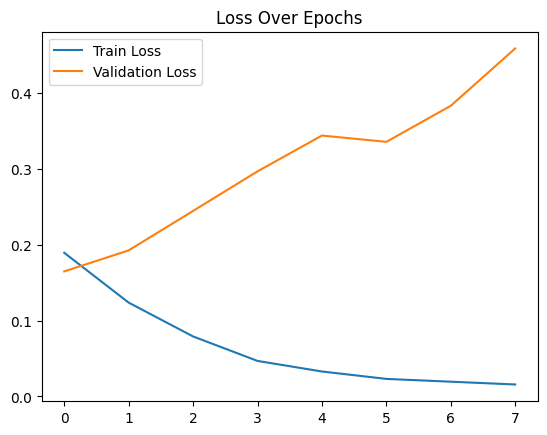

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()


In [18]:

loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")


155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.9386 - loss: 0.2242

✅ Test Accuracy: 94.15%


155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step
AUC Score: 0.7556


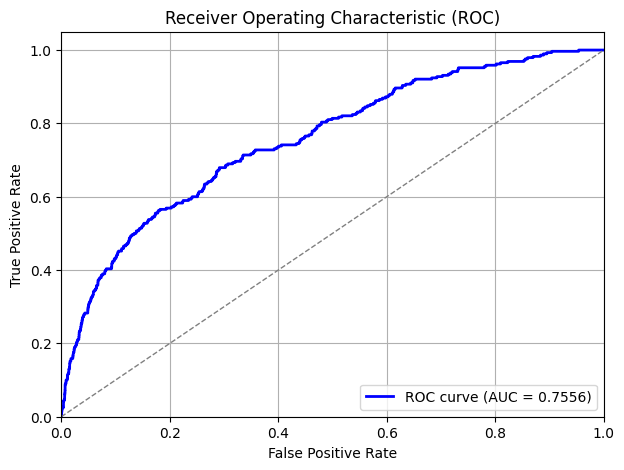

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4667
           1       0.30      0.21      0.25       290

    accuracy                           0.93      4957
   macro avg       0.63      0.59      0.60      4957
weighted avg       0.91      0.93      0.92      4957



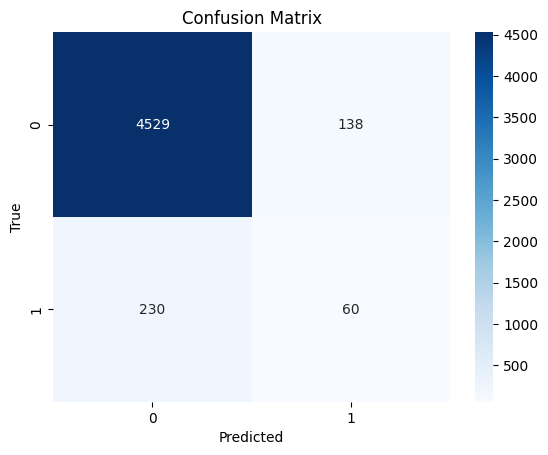

In [ ]:

y_pred = (model.predict(X_test) > 0.5).astype('int32')

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
